# Immgen PRJNA392905 - ATAC-Seq SPAN, MACS2 replicates consistency

Logbook: https://docs.google.com/document/d/1WxzLWUX0PV2TpD0VfwStHczN6YSQ35Uu6DDR-8WX-io/edit#heading=h.xg4nq1px6lhh

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tqdm.auto import tqdm
import tempfile
import re
from itertools import product

In [41]:
PATH = os.path.expanduser('~/data/2023_Immgen')
! mkdir -p {PATH}/pics

def file_to_name(file):
    return re.sub('(.*SRR[0-9]+_)|(_ATAC_seq.*)', '', os.path.basename(file))

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0) # Empty file

def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0 # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

# Macs2

In [4]:
MACS2_FOLDER = PATH + '/macs2atac'
LEVELS = ['q0.05']

dfma = pd.DataFrame(columns=['name', 'tool', 'file', 'peaks'], dtype=object)

for file in tqdm(glob.glob(MACS2_FOLDER + '/*.narrowPeak')):
    tool = next((l for l in LEVELS if f'_{l}_' in file), None)
    if tool:
        name = file_to_name(file)
        dfma.loc[len(dfma)] = (name, f'MACS2 ATAC {tool}', file, lines(file))

dfma['peaks'] = dfma['peaks'].astype(int)

0it [00:00, ?it/s]

In [5]:
MACS2_FOLDER = PATH + '/macs2'
LEVELS = ['q0.05']

dfm = pd.DataFrame(columns=['name', 'tool', 'file', 'peaks'], dtype=object)

for file in tqdm(glob.glob(MACS2_FOLDER + '/*.narrowPeak')):
    tool = next((l for l in LEVELS if f'_{l}_' in file), None)
    if tool:
        name = file_to_name(file)
        dfm.loc[len(dfm)] = (name, f'MACS2 {tool}', file, lines(file))

dfm['peaks'] = dfm['peaks'].astype(int)

  0%|          | 0/185 [00:00<?, ?it/s]

# SPAN

In [6]:
SPAN_FOLDER=PATH + '/span'
FDRS = [0.05]

dfs = pd.DataFrame(columns=['name', 'tool', 'file', 'peaks'], dtype=object)

for file in tqdm(glob.glob(SPAN_FOLDER + '/*.peak')):
    fdr = next((f for f in FDRS if f'{f}' in file), None)
    if fdr:
        name = file_to_name(file)
        dfs.loc[len(dfs)] = (name, f'SPAN {fdr}', file, lines(file))

dfs['peaks'] = dfs['peaks'].astype(int)

  0%|          | 0/185 [00:00<?, ?it/s]

In [7]:
# SPAN_FOLDER=PATH + '/span_atac'
# FDRS = [0.05]
#
# dfsa = pd.DataFrame(columns=['name', 'tool', 'file', 'peaks'], dtype=object)
#
# for file in tqdm(glob.glob(SPAN_FOLDER + '/*00*.peak')):
#     fdr = next((f for f in FDRS if f'_q{f}' in file), None)
#     if fdr:
#         name = file_to_name(file)
#         dfsa.loc[len(dfsa)] = (name, f'SPAN fragment {fdr}', file, lines(file))
#
# dfsa['peaks'] = dfsa['peaks'].astype(int)

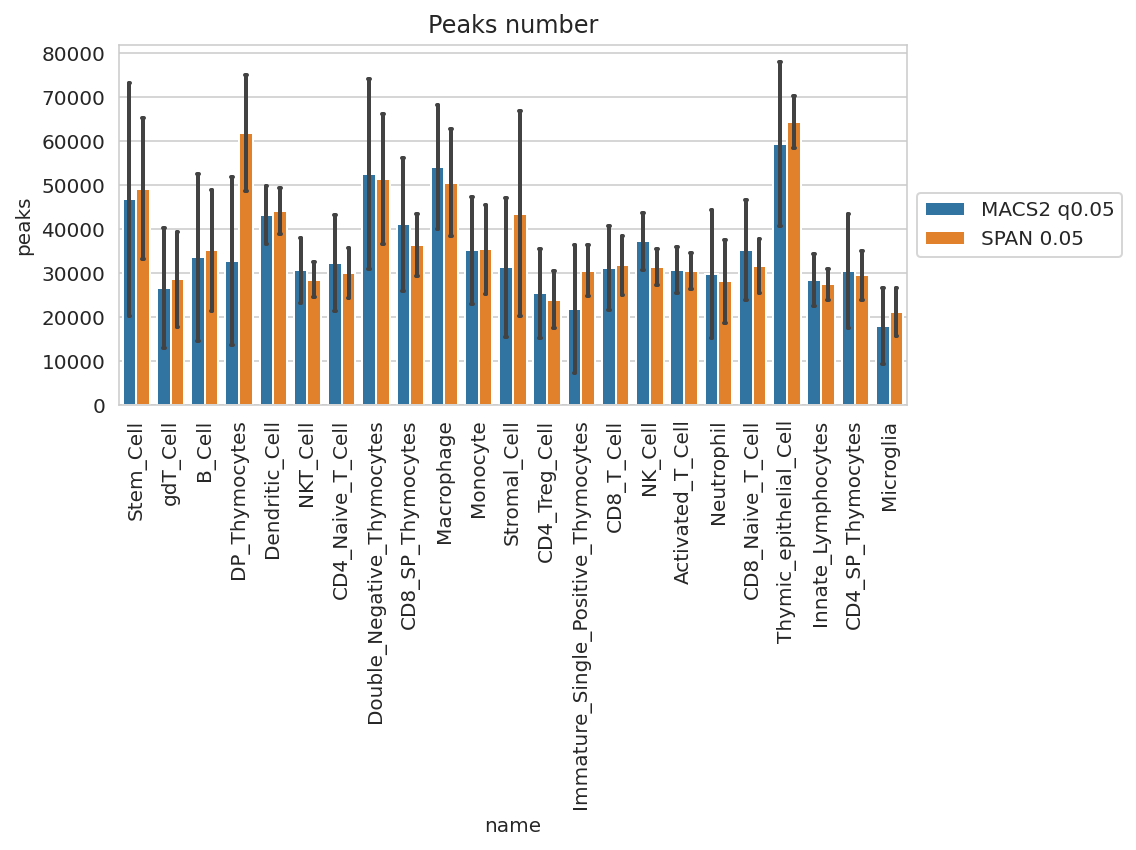

In [42]:
# dfa = pd.concat([dfma, dfm, dfs, dfsa])
dfa = pd.concat([dfma, dfm, dfs, dfs])
plt.figure(figsize=(8, 6))
g_result = sns.barplot(data=dfa, x='name', y='peaks', hue='tool',
            errorbar='sd', capsize=.05, errwidth=2)
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.title('Peaks number')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

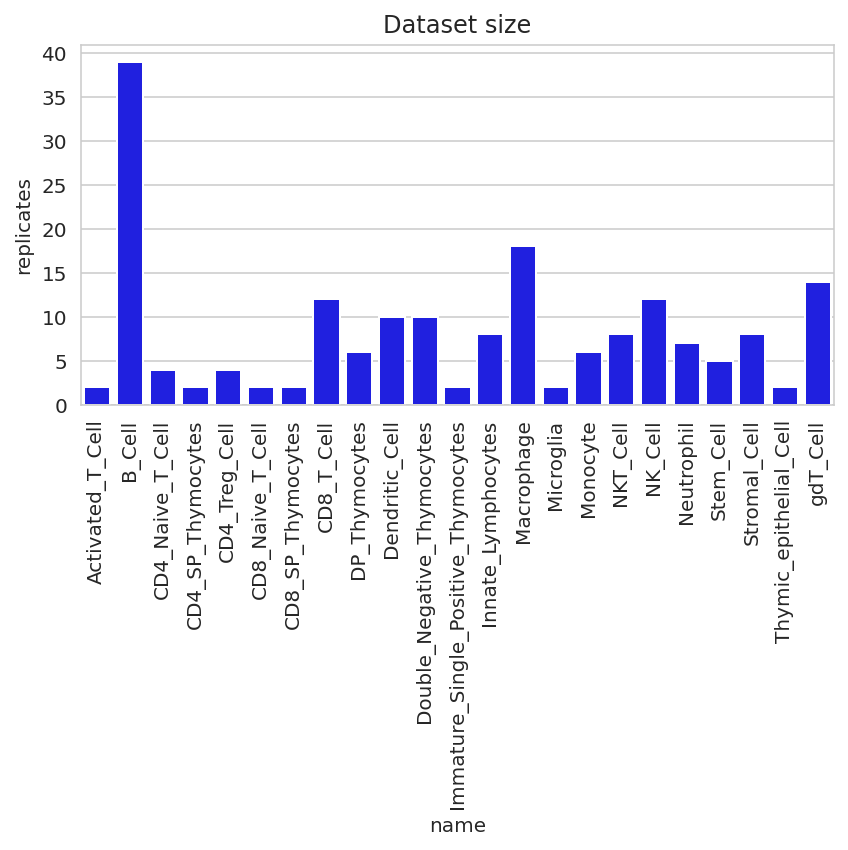

In [47]:
t = (dfm.groupby(['name'])['file'].count() / len(LEVELS)).astype(int)
plt.figure(figsize=(6, 6))
sns.barplot(data=pd.DataFrame(dict(name=t.index, replicates=t)), x='name', y='replicates', color='Blue')
plt.xticks(rotation=90)
plt.title('Dataset size')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/replicates.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [64]:
ts = []
for name, tool, file in tqdm(zip(dfa['name'], dfa['tool'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(name=[name] * len(lengths), tool=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,name,tool,length
172388,Dendritic_Cell,MACS2 q0.05,177
3635164,B_Cell,SPAN 0.05,151
373938,Macrophage,MACS2 q0.05,189
2257103,B_Cell,SPAN 0.05,538
868202,B_Cell,MACS2 q0.05,464
1574733,NKT_Cell,MACS2 q0.05,279
5286272,gdT_Cell,SPAN 0.05,149
4301729,Monocyte,SPAN 0.05,145
1031561,Neutrophil,MACS2 q0.05,448
2047496,Innate_Lymphocytes,SPAN 0.05,362


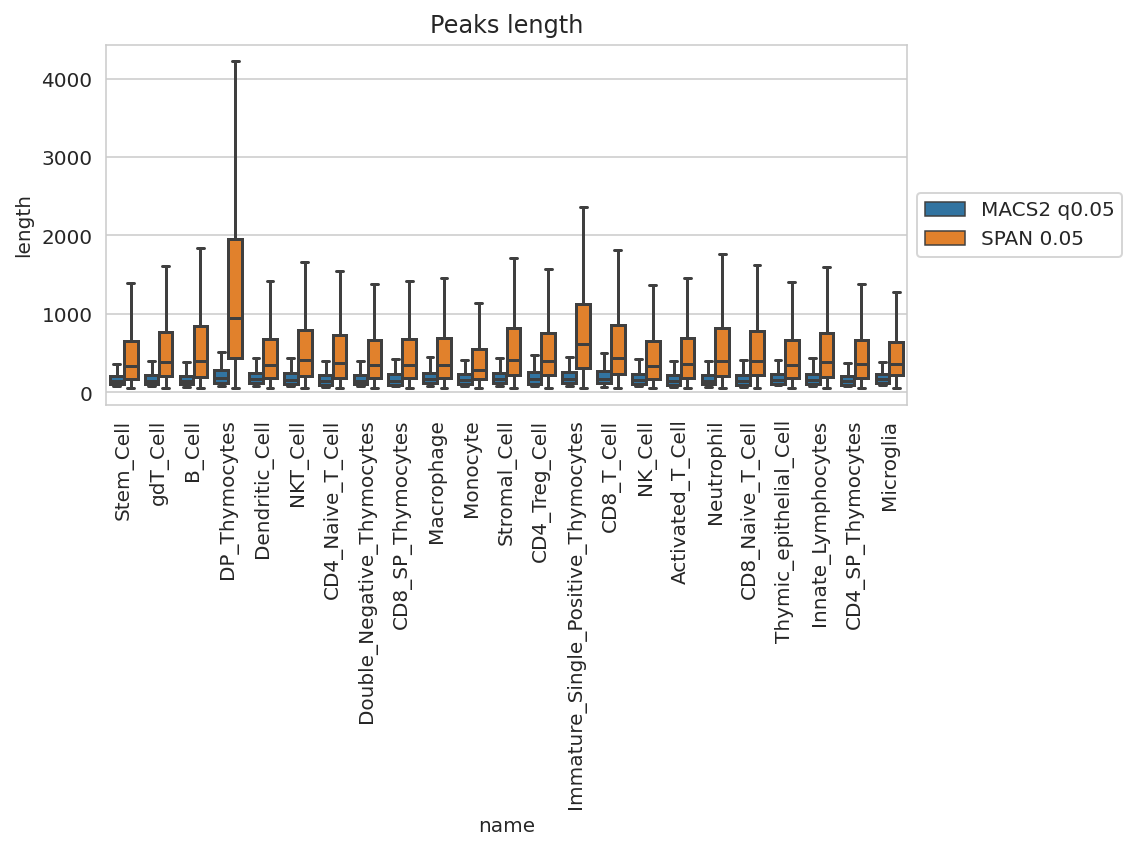

In [66]:
plt.figure(figsize=(8, 6))
g_result = sns.boxplot(data=t, x='name', y='length', hue='tool', showfliers=False)
plt.xticks(rotation=90)
plt.title('Peaks length')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

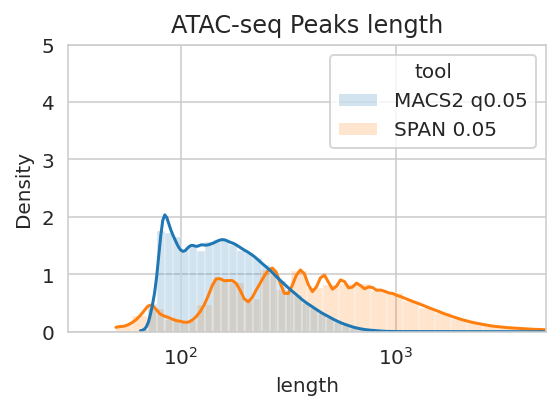

In [51]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.set_ylim(0, 5)
g_results.set_xlim(30, 5e3)
ax.title.set_text('ATAC-seq Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks_length2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Overlaps

In [19]:
def compute_overlaps(df):
    dfoverlap = pd.DataFrame(columns=['name', 'tool', 'file1', 'file2',
                                      'peaks1', 'peaks2', 'overlap12', 'overlap21',
                                      'peaks1_len', 'peaks2_len', 'overlap_len'], dtype=object)
    for n in sorted(set(df['name'])):
        for tool in sorted(set(df['tool'])):
            dfnl = df.loc[(df['name'] == n) &  (df['tool'] == tool)]
            print('Processing', n, tool, len(dfnl))
            files = list(dfnl['file'])
            for i1, i2 in tqdm(product(range(len(files)), range(len(files)))):
                if i1 >= i2:
                    continue
                f1, f2 = files[i1], files[i2]
                peaks1, peaks1_len = lines(f1), bedl(f1).sum()
                peaks2, peaks2_len = lines(f2), bedl(f2).sum()
                f1s, f2s = sorted_file(f1), sorted_file(f2)
                tf = f'{PATH}/overlaps_{tool}_{n}_{tool}_overlaps.bed'.replace(' ', '_')
                !bedtools intersect -a {f1s} -b {f2s} -wa -u > {tf}
                overlap12 = lines(tf)
                !bedtools intersect -b {f1s} -a {f2s} -wa -u > {tf}
                overlap21 = lines(tf)
                !bedtools intersect -a {f1s} -b {f2s} -wo > {tf}
                overlap_len = int(last_col(tf).sum())
                dfoverlap.loc[len(dfoverlap)] = (n, tool, f1, f2,
                                                 peaks1, peaks2, overlap12, overlap21,
                                                 peaks1_len, peaks2_len, overlap_len)
    return dfoverlap

## MACS2 overlaps

In [20]:
dfma_overlap = compute_overlaps(dfma)

In [21]:
dfm_overlap = compute_overlaps(dfm)

Processing Activated_T_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing B_Cell MACS2 q0.05 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell MACS2 q0.05 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell MACS2 q0.05 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD8_T_Cell MACS2 q0.05 12


0it [00:00, ?it/s]

Processing DP_Thymocytes MACS2 q0.05 6


0it [00:00, ?it/s]

Processing Dendritic_Cell MACS2 q0.05 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes MACS2 q0.05 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes MACS2 q0.05 8


0it [00:00, ?it/s]

Processing Macrophage MACS2 q0.05 18


0it [00:00, ?it/s]

Processing Microglia MACS2 q0.05 2


0it [00:00, ?it/s]

Processing Monocyte MACS2 q0.05 6


0it [00:00, ?it/s]

Processing NKT_Cell MACS2 q0.05 8


0it [00:00, ?it/s]

Processing NK_Cell MACS2 q0.05 12


0it [00:00, ?it/s]

Processing Neutrophil MACS2 q0.05 7


0it [00:00, ?it/s]

Processing Stem_Cell MACS2 q0.05 5


0it [00:00, ?it/s]

Processing Stromal_Cell MACS2 q0.05 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing gdT_Cell MACS2 q0.05 14


0it [00:00, ?it/s]

## SPAN overlaps

In [22]:
dfs_overlap = compute_overlaps(dfs)

Processing Activated_T_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing B_Cell SPAN 0.05 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell SPAN 0.05 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell SPAN 0.05 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD8_T_Cell SPAN 0.05 12


0it [00:00, ?it/s]

Processing DP_Thymocytes SPAN 0.05 6


0it [00:00, ?it/s]

Processing Dendritic_Cell SPAN 0.05 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes SPAN 0.05 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes SPAN 0.05 8


0it [00:00, ?it/s]

Processing Macrophage SPAN 0.05 18


0it [00:00, ?it/s]

Processing Microglia SPAN 0.05 2


0it [00:00, ?it/s]

Processing Monocyte SPAN 0.05 6


0it [00:00, ?it/s]

Processing NKT_Cell SPAN 0.05 8


0it [00:00, ?it/s]

Processing NK_Cell SPAN 0.05 12


0it [00:00, ?it/s]

Processing Neutrophil SPAN 0.05 7


0it [00:00, ?it/s]

Processing Stem_Cell SPAN 0.05 5


0it [00:00, ?it/s]

Processing Stromal_Cell SPAN 0.05 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing gdT_Cell SPAN 0.05 14


0it [00:00, ?it/s]

In [23]:
# dfsa_overlap = compute_overlaps(dfsa)

In [24]:
# dfao = pd.concat([dfma_overlap, dfm_overlap, dfs_overlap, dfsa_overlap])
dfao = pd.concat([dfma_overlap, dfm_overlap, dfs_overlap])
dfao['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(dfao['peaks1_len'], dfao['peaks2_len'], dfao['overlap_len'])
]

Jaccard


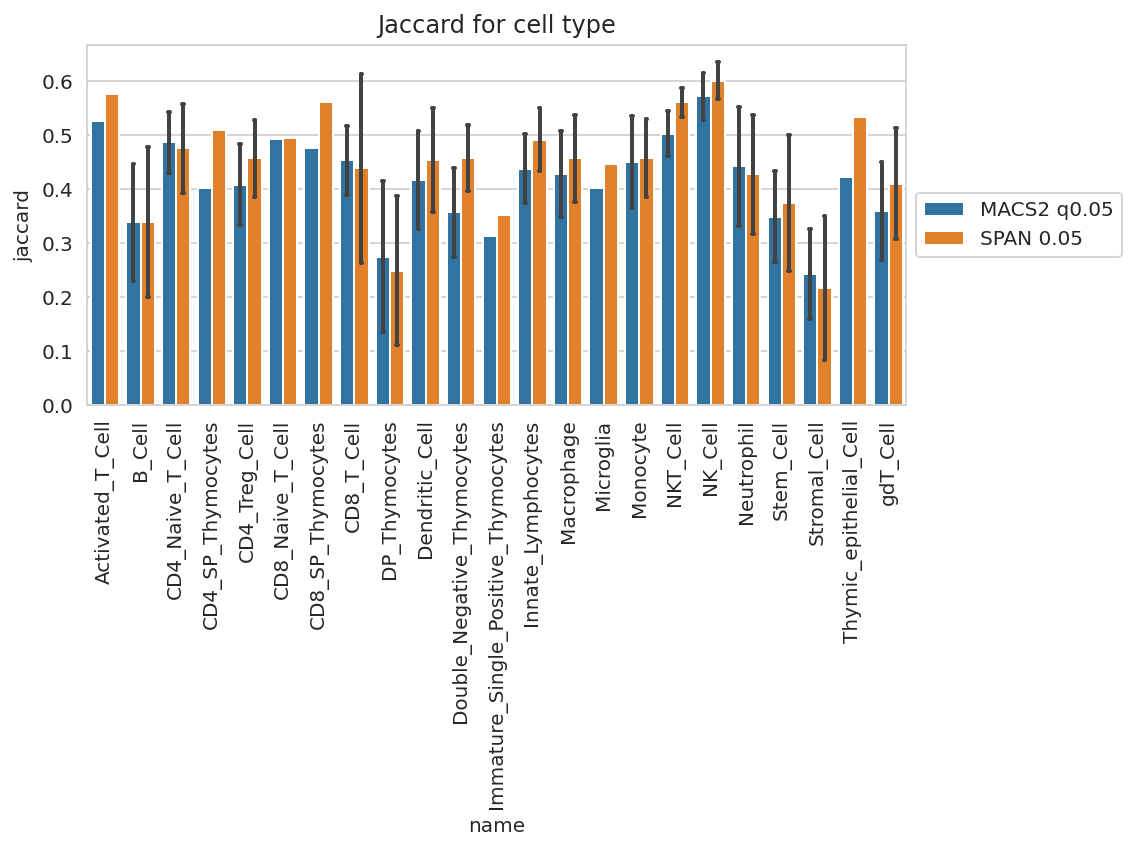

In [68]:
print('Jaccard')

plt.figure(figsize=(8, 6))
g_result = sns.barplot(data=dfao,
            x='name', y='jaccard', hue='tool',
            errorbar='sd', capsize=.05, errwidth=2)
plt.xticks(rotation=90)
plt.title('Jaccard for cell type')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Overlap with DHS

In [55]:
from itertools import product

DHS_PATH = sorted_file(f'{PATH}/ENCFF754WCT_mm10_dhs_representative_sites.bed')
DHS_PEAKS = lines(DHS_PATH)

def compute_dhs_overlaps(df):
    dfoverlap = pd.DataFrame(columns=['name', 'tool', 'file', 'way', 'peaks', 'overlap'], dtype=object)
    for n in sorted(set(df['name'])):
        for tool in sorted(set(df['tool'])):
            dfnl = df.loc[(df['name'] == n) &  (df['tool'] == tool)]
            print('Processing', n, tool, len(dfnl))
            for _, row in tqdm(dfnl.iterrows()):
                file, peaks = sorted_file(row['file']), row['peaks']

                tf = f'{PATH}/overlaps_{tool}_{n}_{tool}_vs_dhs.bed'.replace(' ', '_')
                !bedtools intersect -a {file} -b {DHS_PATH} -wa -u > {tf}
                owd = lines(tf)
                dfoverlap.loc[len(dfoverlap)] = (n, tool, file, 'with_dhs', peaks, owd)

                tf = f'{PATH}/overlaps_{tool}_{n}_{tool}_dhs_vs.bed'.replace(' ', '_')
                !bedtools intersect -b {file} -a {DHS_PATH} -wa -u > {tf}
                odw = lines(tf)
                dfoverlap.loc[len(dfoverlap)] = (n, tool, file, 'dhs_with', DHS_PEAKS, odw)
    return dfoverlap

In [56]:
dfma_dhs_overlap = compute_dhs_overlaps(dfma)

In [57]:
dfm_dhs_overlap = compute_dhs_overlaps(dfm)

Processing Activated_T_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing B_Cell MACS2 q0.05 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell MACS2 q0.05 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell MACS2 q0.05 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD8_T_Cell MACS2 q0.05 12


0it [00:00, ?it/s]

Processing DP_Thymocytes MACS2 q0.05 6


0it [00:00, ?it/s]

Processing Dendritic_Cell MACS2 q0.05 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes MACS2 q0.05 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes MACS2 q0.05 8


0it [00:00, ?it/s]

Processing Macrophage MACS2 q0.05 18


0it [00:00, ?it/s]

Processing Microglia MACS2 q0.05 2


0it [00:00, ?it/s]

Processing Monocyte MACS2 q0.05 6


0it [00:00, ?it/s]

Processing NKT_Cell MACS2 q0.05 8


0it [00:00, ?it/s]

Processing NK_Cell MACS2 q0.05 12


0it [00:00, ?it/s]

Processing Neutrophil MACS2 q0.05 7


0it [00:00, ?it/s]

Processing Stem_Cell MACS2 q0.05 5


0it [00:00, ?it/s]

Processing Stromal_Cell MACS2 q0.05 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing gdT_Cell MACS2 q0.05 14


0it [00:00, ?it/s]

In [58]:
dfs_dhs_overlap = compute_dhs_overlaps(dfs)

Processing Activated_T_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing B_Cell SPAN 0.05 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell SPAN 0.05 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell SPAN 0.05 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD8_T_Cell SPAN 0.05 12


0it [00:00, ?it/s]

Processing DP_Thymocytes SPAN 0.05 6


0it [00:00, ?it/s]

Processing Dendritic_Cell SPAN 0.05 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes SPAN 0.05 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes SPAN 0.05 8


0it [00:00, ?it/s]

Processing Macrophage SPAN 0.05 18


0it [00:00, ?it/s]

Processing Microglia SPAN 0.05 2


0it [00:00, ?it/s]

Processing Monocyte SPAN 0.05 6


0it [00:00, ?it/s]

Processing NKT_Cell SPAN 0.05 8


0it [00:00, ?it/s]

Processing NK_Cell SPAN 0.05 12


0it [00:00, ?it/s]

Processing Neutrophil SPAN 0.05 7


0it [00:00, ?it/s]

Processing Stem_Cell SPAN 0.05 5


0it [00:00, ?it/s]

Processing Stromal_Cell SPAN 0.05 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing gdT_Cell SPAN 0.05 14


0it [00:00, ?it/s]

In [59]:
# dfsa_dhs_overlap = compute_dhs_overlaps(dfsa)

In [60]:
# dhs_overlap = pd.concat([dfma_dhs_overlap, dfm_dhs_overlap, dfs_dhs_overlap, dfsa_dhs_overlap])
dhs_overlap = pd.concat([dfma_dhs_overlap, dfm_dhs_overlap, dfs_dhs_overlap])
dhs_overlap['overlap'] = [o / p if p > 0 else 0 for o, p in zip(dhs_overlap['overlap'], dhs_overlap['peaks'])]

In [61]:
dhs_overlap

,name,tool,file,way,peaks,overlap
0,Activated_T_Cell,MACS2 q0.05,/tmp/tmpwuek9hu_,with_dhs,34392,0.960921
1,Activated_T_Cell,MACS2 q0.05,/tmp/tmpwuek9hu_,dhs_with,1192301,0.027929
2,Activated_T_Cell,MACS2 q0.05,/tmp/tmp1qg47lq0,with_dhs,27053,0.967693
3,Activated_T_Cell,MACS2 q0.05,/tmp/tmp1qg47lq0,dhs_with,1192301,0.022504
4,B_Cell,MACS2 q0.05,/tmp/tmp3mxjqqit,with_dhs,9853,0.979093
...,...,...,...,...,...,...
365,gdT_Cell,SPAN 0.05,/tmp/tmprp45iyvs,dhs_with,1192301,0.060326
366,gdT_Cell,SPAN 0.05,/tmp/tmptc_yapqy,with_dhs,14987,0.972843
367,gdT_Cell,SPAN 0.05,/tmp/tmptc_yapqy,dhs_with,1192301,0.021534
368,gdT_Cell,SPAN 0.05,/tmp/tmpcx2c13jc,with_dhs,28323,0.972461


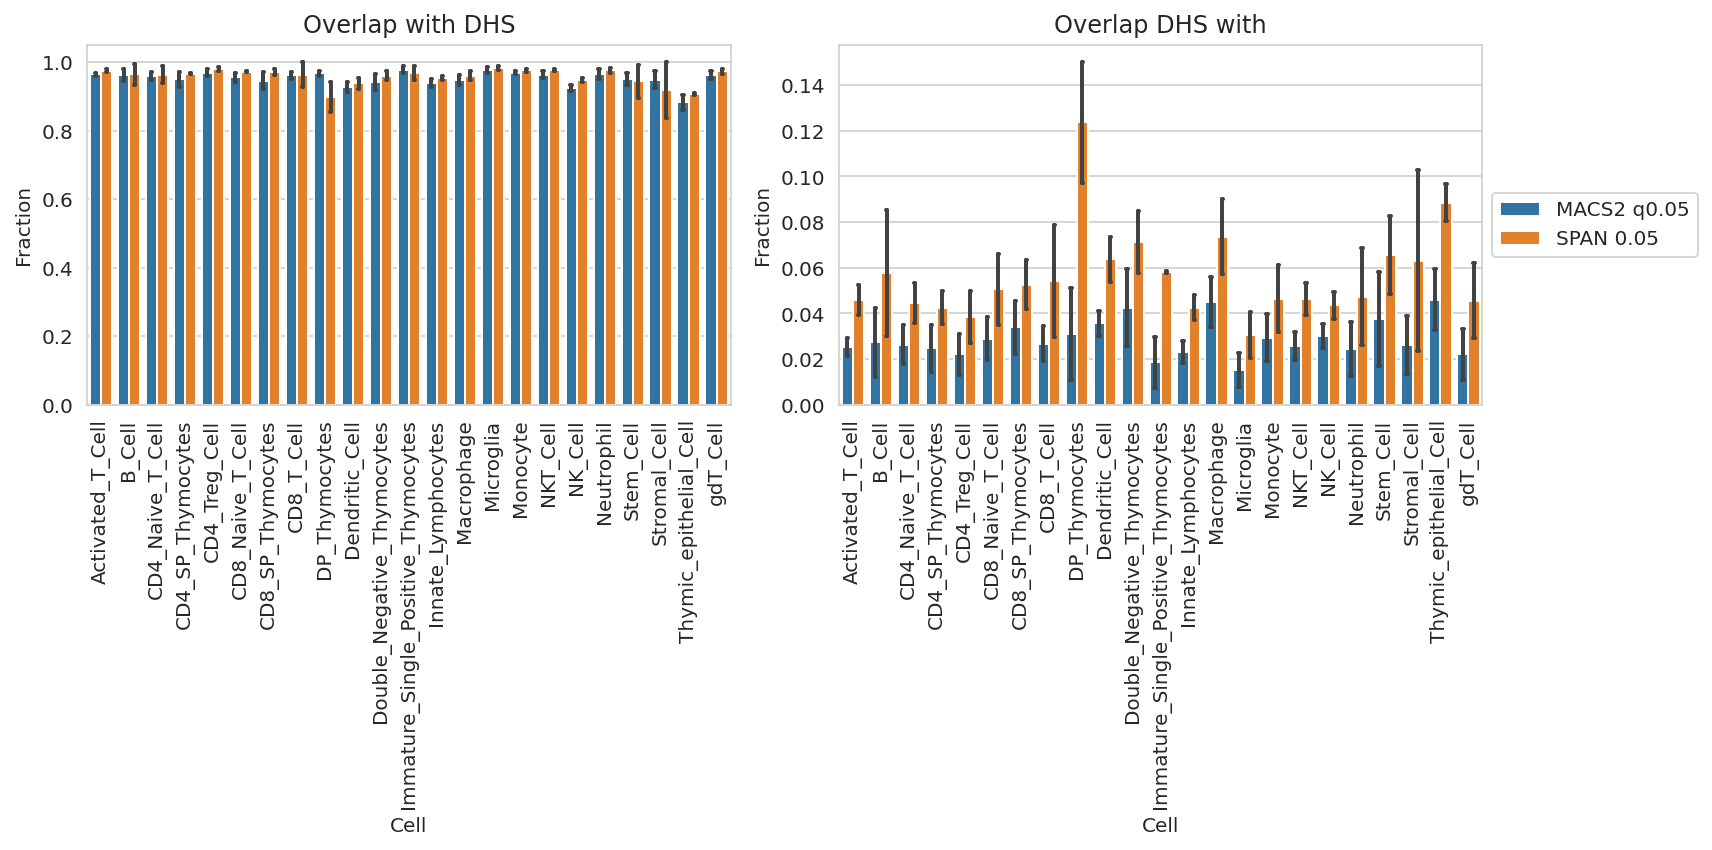

In [74]:
plt.figure(figsize=(12, 6))
# Plot 
ax = plt.subplot(1, 2, 1)
ax.title.set_text('Overlap with DHS')
sns.barplot(data=dhs_overlap[dhs_overlap['way']=='with_dhs'], x='name', y='overlap', hue='tool',
            errorbar='sd', capsize=.05, errwidth=2, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('Cell')
ax.set_ylabel('Fraction')
ax.legend(loc='lower left', title='tool')
ax.legend().set_visible(False)

ax = plt.subplot(1, 2, 2)
ax.title.set_text('Overlap DHS with')
t = dhs_overlap[dhs_overlap['way']=='dhs_with'].copy()
t['overlap'].clip(upper=0.15, inplace=True)
sns.barplot(data=t, x='name', y='overlap', hue='tool',
            errorbar='sd', capsize=.05, errwidth=2, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('Cell')
ax.set_ylabel('Fraction')
ax.legend(loc='lower left', title='tool')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{PATH}/pics/dhs.pdf', bbox_inches='tight', dpi=300)
plt.show()